In [1]:
%matplotlib inline

import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from biom.util import biom_open

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from scipy.stats import pearsonr, spearmanr

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

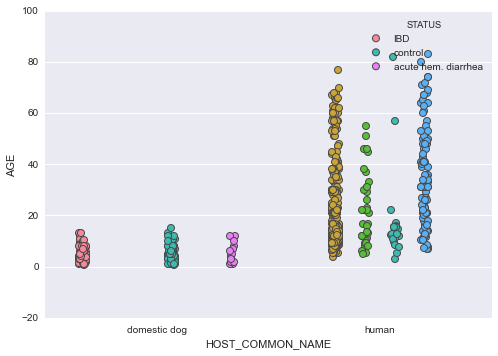

In [10]:
mf = load_mf('combined-gevers-suchdolski/mapping-file.standardized.txt')

mf.AGE = pd.to_numeric(mf.AGE, errors='coerce')

mf = mf[mf.BIOPSY_LOCATION.isin(['stool', 'no_data'])]

sns.stripplot('HOST_COMMON_NAME', 'AGE', data=mf, jitter=True,
              edgecolor='gray', hue='STATUS')

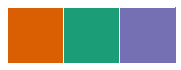

In [9]:
ibd_colors = sns.color_palette(["#d95f02", "#1b9e77", "#7570b3"])
sns.palplot(ibd_colors)

sns.set_palette(ibd_colors)

In [11]:
mf.HOST_COMMON_NAME.value_counts()

human           520
domestic dog    192
Name: HOST_COMMON_NAME, dtype: int64

# Compute alpha diversity

In [12]:
!echo 'alpha_diversity:metrics PD_whole_tree,shannon,observed_species,chao1' > combined-gevers-suchdolski/alpha-params.txt
!echo 'make_rarefaction_plots:colorby HOST_COMMON_NAME,DISEASE_STAT' >> combined-gevers-suchdolski/alpha-params.txt

In [13]:
!alpha_rarefaction.py -i combined-gevers-suchdolski/otu-table.biom \
-o combined-gevers-suchdolski/alpha \
-m combined-gevers-suchdolski/mapping-file.standardized.txt \
-a -O 6 --min_rare_depth 15000 -e 15000 \
-p combined-gevers-suchdolski/alpha-params.txt \
-t gg_13_8_otus/trees/97_otus.tree

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [14]:
!add_alpha_to_mapping_file.py -i combined-gevers-suchdolski/alpha/alpha_div_collated/PD_whole_tree.txt,\
combined-gevers-suchdolski/alpha/alpha_div_collated/chao1.txt,\
combined-gevers-suchdolski/alpha/alpha_div_collated/observed_species.txt,\
combined-gevers-suchdolski/alpha/alpha_div_collated/shannon.txt \
-m combined-gevers-suchdolski/mapping-file.standardized.txt \
-o combined-gevers-suchdolski/mapping-file.standardized.alpha.txt \
--depth 15000 --collated_input

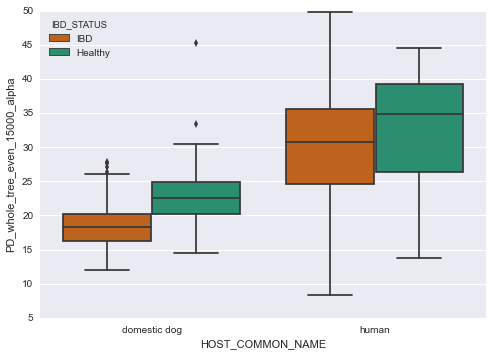

In [15]:
mf = load_mf('combined-gevers-suchdolski/mapping-file.standardized.alpha.amended.txt')

mf.PD_whole_tree_even_15000_alpha = pd.to_numeric(mf.PD_whole_tree_even_15000_alpha, errors='coerce')
mf.AGE = pd.to_numeric(mf.AGE, errors='coerce')

mf = mf[mf.BIOPSY_LOCATION.isin(['stool', 'no_data'])]

sns.boxplot('HOST_COMMON_NAME', 'PD_whole_tree_even_15000_alpha', hue='IBD_STATUS', data=mf)

plt.savefig('combined-gevers-suchdolski/alpha-diversity-comparison.pdf')

In [16]:
mf[mf.HOST_COMMON_NAME == 'human']['IBD_STATUS'].value_counts()

IBD        490
Healthy     30
Name: IBD_STATUS, dtype: int64

In [18]:
mf.HOST_COMMON_NAME.value_counts()

human           520
domestic dog    192
Name: HOST_COMMON_NAME, dtype: int64

In [19]:
mf = load_mf('combined-gevers-suchdolski/mapping-file.standardized.alpha.txt')

def funk(row):
    if row['HOST_COMMON_NAME'] == 'human':
        # we want to standardize the values of this column
        if row['STATUS'] in {'UC', 'CD', 'IC'}:
            return 'IBD'
        else:
            return 'Healthy'
    elif row['HOST_COMMON_NAME'] == 'domestic dog':
        if row['STATUS'] == 'accute hem. diarrhea':
            return 'NA'
        elif row['STATUS'] == 'control':
            return 'Healthy'
        else:
            return 'IBD'
mf['IBD_STATUS'] = mf.apply(funk, axis=1, reduce=True)

write_mf('combined-gevers-suchdolski/mapping-file.standardized.alpha.amended.txt', mf)

In [23]:
mf.IBD_STATUS.value_counts()

IBD        1653
Healthy     496
Name: IBD_STATUS, dtype: int64

In [21]:
mf.BIOPSY_LOCATION.value_counts()

Terminalileum      743
stool              520
Rectum             446
no_data            192
Descendingcolon     78
Cecum               61
Sigmoid             50
Ascendingcolon      29
Transversecolon     20
J-Pouch              4
Neo-ileum            4
Recto-Sigmoid        2
Name: BIOPSY_LOCATION, dtype: int64

In [211]:
rm -rf combined-gevers-suchdolski/ibd-comparison

In [24]:
%%bash

mkdir -p combined-gevers-suchdolski/ibd-comparison

for STAT in Healthy IBD
do
    filter_samples_from_otu_table.py -i combined-gevers-suchdolski/otu-table.15000.biom \
    -m combined-gevers-suchdolski/mapping-file.standardized.alpha.amended.txt \
    -s "IBD_STATUS:${STAT};BIOPSY_LOCATION:stool,no_data" \
    --output_fp combined-gevers-suchdolski/ibd-comparison/otu-table-${STAT}.15000.biom \
    --output_mapping_fp combined-gevers-suchdolski/ibd-comparison/mapping-file-${STAT}.15000.txt

    filter_otus_from_otu_table.py -s 50 \
    -i combined-gevers-suchdolski/ibd-comparison/otu-table-${STAT}.15000.biom \
    -o combined-gevers-suchdolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom

    summarize_taxa.py \
    -i combined-gevers-suchdolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom \
    -o combined-gevers-suchdolski/ibd-comparison/taxa-summaries-${STAT}-40pct \
    -m combined-gevers-suchdolski/ibd-comparison/mapping-file-${STAT}.15000.txt

    summarize_taxa.py \
    -i combined-gevers-suchdolski/ibd-comparison/otu-table-${STAT}.15000.40pct.biom \
    -o combined-gevers-suchdolski/ibd-comparison/taxa-summaries-${STAT}-40pct

    group_significance.py \
    -i combined-gevers-suchdolski/ibd-comparison/taxa-summaries-${STAT}-40pct/otu-table-${STAT}.15000.40pct_L6.biom \
    -m combined-gevers-suchdolski/ibd-comparison/mapping-file-${STAT}.15000.txt \
    -o combined-gevers-suchdolski/ibd-comparison/taxa-summaries-${STAT}-40pct/kruskall-wallis-L6-${STAT}.txt \
    -c HOST_COMMON_NAME
done